# City of Melbourne Parking Analysis

In this notebook we analyse real time parking data from the City of Melbourne (CoM). We have set up a process using the prefect library to extract real time parking data in 10 minute intervals.

In [369]:
import pandas as pd
import numpy as np
import os
import powerlaw


In [925]:
# read all files in data folder
df_array = []
file_count = 0

for _file in os.listdir(r'./data_prep/raw_data'):
    if _file != '_SS':
        out = pd.read_csv(r'./data_prep/raw_data/' + _file)
        df_array.append(out)
        file_count += 1

df = pd.concat(df_array)
df.datetime = pd.to_datetime(df.datetime)
df.set_index(['datetime','bay_id'], inplace=True)
df

st_marker_id  status
datetime            bay_id                     
2022-01-06 11:20:00 4432          C7704       0
                    5236         11526N       0
                    2655         10159W       1
                    2670         10179W       1
                    1274          4466E       0
...                                 ...     ...
2022-01-08 09:40:00 4111          C6374       1
                    2644         10118E       1
                    2684         10193W       0
                    2691         10200E       0
                    950            C806       1

[240806 rows x 2 columns]

In [926]:
# parking locations which have data for all counts
obs_counts = df.groupby(level = 'bay_id').count()
obs_counts[(obs_counts.status == file_count)].shape[0]

771

In [927]:
good_bays = obs_counts[(obs_counts.status == file_count)].index.get_level_values('bay_id').unique()
df = df[df.index.get_level_values('bay_id').isin(good_bays)]
df

st_marker_id  status
datetime            bay_id                     
2022-01-06 11:20:00 4432          C7704       0
                    2655         10159W       1
                    2670         10179W       1
                    4044          C6126       1
                    4257          C6846       0
...                                 ...     ...
2022-01-08 09:40:00 4111          C6374       1
                    2644         10118E       1
                    2684         10193W       0
                    2691         10200E       0
                    950            C806       1

[215109 rows x 2 columns]

In [928]:
# create dataset
# variables
# lagged status
df.sort_index()
df['lag1'] = df['status'].groupby(level = 'bay_id').shift(1)
df['lag2'] = df['status'].groupby(level = 'bay_id').shift(2)
df['lag3'] = df['status'].groupby(level = 'bay_id').shift(3)
# neighbouring occupancies (how to find?)
# restrictions?

df


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

st_marker_id  status  lag1  lag2  lag3
datetime            bay_id                                       
2022-01-06 11:20:00 4432          C7704       0   NaN   NaN   NaN
                    2655         10159W       1   NaN   NaN   NaN
                    2670         10179W       1   NaN   NaN   NaN
                    4044          C6126       1   NaN   NaN   NaN
                    4257          C6846       0   NaN   NaN   NaN
...                                 ...     ...   ...   ...   ...
2022-01-08 09:40:00 4111          C6374       1   1.0   1.0   1.0
                    2644         10118E       1   0.0   0.0   0.0
                    2684         10193W       0   1.0   0.0   1.0
                    2691         10200E       0   1.0   1.0   1.0
                    950            C806       1   1.0   1.0   1.0

[215109 rows x 5 columns]

We want to build a predictive model of parking in the CoM. We anticipate that we will build this using a classification model, which will classify a parking space as either occupied or not. A likely variable to use in this model will be the lagged values for the parking occupancy (i.e. whether the car space was occupied 10, 20, 30,... minutes ago). We examine various lags below and plot them - looking at the percentage of car spaces that have the same value in different time periods.

We see that as the lag gets larger, the proportion of matching values drops away sharply to flatten out at around 65%. This is interesting given that if the probability of being occupied and unoccupied were equal, we would expect to see this value converge to 50% as the time lag gets larger. As we see it reduce to 65% (approx) it may be that one state is more common than the other.

In [929]:

out = {'perc':[]}
for i in range(1, 144):
    lagged = df['status'].groupby(level = 'bay_id').shift(i)
    filt = lagged.isna()
    filt_lagged = lagged[~filt]
    filt_curr = df[~filt]
    out['perc'].append(round(100*sum(filt_curr.status == filt_lagged) / filt_curr.shape[0], 1))



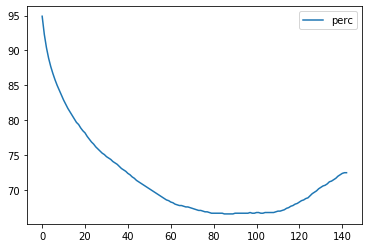

In [930]:
# seems that closer lags (1 to 5) predict greater than or equal 80% (at this time)
pd.DataFrame(out).plot()

We aggregate all bays across time in df_time and look at the percentage that are occupied. Over time we see that this does not really exceed 45%. It appears that there are generally more unoccupied spots than occupied.
Note that currently this data is extracted for a holiday period during a COVID19 outbreak so this may not reflect normal behaviour - however, it does appear to lend weight to our hypothesis that one parking state is more likely than another. 

To analyse this further we may want to look at whether the occupancy rate varies by location or parking type.

In [931]:
df_time = df.copy(deep = True)
df_time.reset_index(inplace = True)

dates = pd.DatetimeIndex(df_time.datetime)

df_time = df_time[['bay_id', 'status', 'lag1', 'lag2', 'lag3']].set_index(dates)

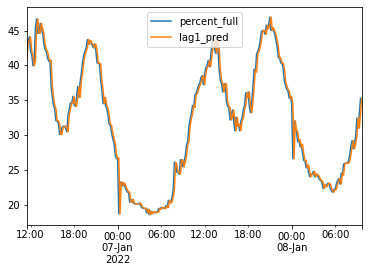

In [932]:
macro_time_df = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    macro_time_df.loc[date, 'percent_full'] = 100*df_time.loc[date, 'status'].sum() / df_time.loc[date, 'status'].count()
    macro_time_df.loc[date, 'lag1_pred'] = 100*df_time.loc[date, 'lag1'].sum() / df_time.loc[date, 'status'].count()

macro_time_df[macro_time_df.lag1_pred > 0].plot()

In [933]:
# parking restrictions data
park_r = pd.read_csv('./data_prep/datasets/parking_bay_restrictions.csv')
park_r.rename(columns = {'BayID': 'bay_id'}, inplace = True)
park_r.set_index('bay_id', inplace = True)
park_r.head()

,DeviceID,Description1,Description2,Description3,Description4,Description5,Description6,DisabilityExt1,DisabilityExt2,DisabilityExt3,...,ToDay3,ToDay4,ToDay5,ToDay6,TypeDesc1,TypeDesc2,TypeDesc3,TypeDesc4,TypeDesc5,TypeDesc6
bay_id,,,,,,,,,,,,,,,,,,,,,
8634,28003,2P RPA 1B 7:30-23:00 M-SUN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,...,NaN,NaN,NaN,NaN,2P,NaN,NaN,NaN,NaN,NaN
8587,27956,2P RPA 1B 7:30-23:00 M-SUN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,...,NaN,NaN,NaN,NaN,2P,NaN,NaN,NaN,NaN,NaN
8498,27876,2P RPA 1B 7:30-23:00 M-SUN,NaN,NaN,NaN,NaN,NaN,240,NaN,NaN,...,NaN,NaN,NaN,NaN,2P,NaN,NaN,NaN,NaN,NaN
3156,26011,3P MTR M-SAT 7:30-20:30,2P SUN 7:30-18:30,NaN,NaN,NaN,NaN,360,240.0,NaN,...,NaN,NaN,NaN,NaN,3P Meter,2P,NaN,NaN,NaN,NaN
8167,25546,1P M-SUN 7:30-23:00,NaN,NaN,NaN,NaN,NaN,120,NaN,NaN,...,NaN,NaN,NaN,NaN,1P,NaN,NaN,NaN,NaN,NaN


In [934]:
all_park_df = df.join(park_r, how = 'inner')
all_park_df.Description1.unique()
# restrictions seem to have:
# xP where x is the number of permitted hours (or less - sometimes only minutes - perhaps remove minute parks from dataset)
# sometimes LZ (loading zone) - may want to remove these from the dataset also
# a time and a day window where the restriction applies
# other text codes with unclear meaning - eg MTR, RPA, 1B?
# seems to be inconsistently recorded codes

array(['1P MTR M-F 7:30-18:30', '4P MTR M-F 7:30-18:30',
       '2P TKT A M-SAT 7:30-20:30', '1/2P M-SUN 7:30AM-11PM',
       '1/2P MTR M-SAT 7.30 TO 18.30', '2P MTR M-SAT 7:30-18:30',
       '1 PM Mon-Sat 7.30-23.00', '1P MTR M-F 7:30-16:00',
       '1/4P 9.30am-4.30pm M-F', '2P MTR RPA M-F 7:30-18:30',
       '1P MTR M-SAT 7:30-18:30', '3P MTR M-SAT 7:30-20:30',
       '2P MTR M-SAT 7:30-20:30', '4P MTR M-SAT 7:30-18:30',
       '2P DIS ONLY 7.30 - 20.30', '2P MTR M-F 7:30-18:30',
       '1P RPA M-SUN 7:30-23:00', '1/4P M-F 9:30-16:00',
       '2P M-F 7:30-18:30', 'LZ 30M M-F 7:30-19:30',
       'LZ 15M M-F 7:30-18:30', '4P TKT A M-F 7:30-18:30',
       '4P RPA M-F 7:30-18:30', '3P MTR M-F 10:00-16:00',
       '4P M-F 7:30-18:30', '2P RPA M-F 7:30-18:30',
       'CW TOW M-F 7:00-10:00', '1/4P M-F 7:30-18:30',
       '1/4P M-F 7.30 - 4.30', '1/2P AOT RPE 7.30 - 6.30',
       'LZ 30MINS -722 - M-F 7.30-19.30', 'P DIS AOT 20:30 TO 23:59',
       'L/Zone 30MINS 7.30 - 6.30PM', '1P A RPE 

In [935]:
all_park_df.TypeDesc1.unique()

array(['1P Meter', '4P Meter', '2P Ticket A', '1/2P', '1/2P Meter',
       '2P Meter', '1/4P', '3P Meter', '2P Disabled Only', '1P', '2P',
       'Loading Zone 30M', 'Loading Zone 15M', '4P Ticket A', '4P',
       'Clearway (Tow away)', 'Loading Zone 30M 722', 'Disabled Only',
       '4P Disabled Only', '1P Disabled Only', '1P Ticket A', 'P 10 Mins',
       '3P Disabled Only', '3P'], dtype=object)

In [936]:
import re
# pattern = r'\dP'
# [re.match(pattern, desc) for desc in all_park_df.TypeDesc1.unique()]

def extract_hrs(string):
    pattern = r'\dP'
    res = re.match(pattern, string)
    if res:
        return res.group()
    else:
        return '0'

all_park_df.loc[:, 'hours'] = all_park_df.TypeDesc1.apply(lambda x: extract_hrs(x))
all_park_df

st_marker_id  status  lag1  lag2  lag3  DeviceID  \
datetime            bay_id                                                    
2022-01-06 11:20:00 2655         10159W       1   NaN   NaN   NaN     25009   
                    2670         10179W       1   NaN   NaN   NaN     23243   
                    4044          C6126       1   NaN   NaN   NaN     29785   
                    4257          C6846       0   NaN   NaN   NaN     24903   
                    3027          5123W       0   NaN   NaN   NaN     26595   
...                                 ...     ...   ...   ...   ...       ...   
2022-01-08 09:40:00 4111          C6374       1   1.0   1.0   1.0     25130   
                    2644         10118E       1   0.0   0.0   0.0     24881   
                    2684         10193W       0   1.0   0.0   1.0     25018   
                    2691         10200E       0   1.0   1.0   1.0     26707   
                    950            C806       1   1.0   1.0   1.0     26528   

                                         Description1           Description2  \
datetime            bay_id                                                     
2022-01-06 11:20:00 2655        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    2670        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    4044        4P MTR M-F 7:30-18:30  4P MTR SAT 7:30-12:30   
                    4257    2P TKT A M-SAT 7:30-20:30      2P SUN 7:30-18:30   
                    3027       1/2P M-SUN 7:30AM-11PM                    NaN   
...                                               ...                    ...   
2022-01-08 09:40:00 4111        4P MTR M-F 7:30-18:30  4P MTR SAT 7:30-12:30   
                    2644        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    2684        1P MTR M-F 7:30-18:30  1P MTR SAT 7:30-12:30   
                    2691      1P DIS M-SUN 0:00-23:59                    NaN   
                    950       2P MTR M-SAT 7:30-20:30      1P SUN 7:30-18:30   

                           Description3 Description4  ... ToDay4 ToDay5  \
datetime            bay_id                            ...                 
2022-01-06 11:20:00 2655            NaN          NaN  ...    NaN    NaN   
                    2670            NaN          NaN  ...    NaN    NaN   
                    4044            NaN          NaN  ...    NaN    NaN   
                    4257            NaN          NaN  ...    NaN    NaN   
                    3027            NaN          NaN  ...    NaN    NaN   
...                                 ...          ...  ...    ...    ...   
2022-01-08 09:40:00 4111            NaN          NaN  ...    NaN    NaN   
                    2644            NaN          NaN  ...    NaN    NaN   
                    2684            NaN          NaN  ...    NaN    NaN   
                    2691            NaN          NaN  ...    NaN    NaN   
                    950             NaN          NaN  ...    NaN    NaN   

                            ToDay6         TypeDesc1  TypeDesc2  TypeDesc3  \
datetime            bay_id                                                   
2022-01-06 11:20:00 2655       NaN          1P Meter   1P Meter        NaN   
                    2670       NaN          1P Meter   1P Meter        NaN   
                    4044       NaN          4P Meter   4P Meter        NaN   
                    4257       NaN       2P Ticket A         2P        NaN   
                    3027       NaN              1/2P        NaN        NaN   
...                            ...               ...        ...        ...   
2022-01-08 09:40:00 4111       NaN          4P Meter   4P Meter        NaN   
                    2644       NaN          1P Meter   1P Meter        NaN   
                    2684       NaN          1P Meter   1P Meter        NaN   
                    2691       NaN  1P Disabled Only        NaN        NaN   
                    950        NaN          2P

In [940]:
# how to extract parking spots with variable times?
# indicator variable indicating permissable hours by time and day
# e.g. 1P, 2P, 3P, 4P - but include indicator values only at time / day
# add available variable - if not loading zone at certain times then 0 etc.


In [941]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
# set up modelling data
estimation_data = all_park_df[['status', 'lag1', 'lag2', 'lag3', 'hours']].copy(deep = True)
estimation_data = estimation_data.loc[~estimation_data.lag3.isna(), ['status', 'lag1', 'lag2', 'lag3', 'hours']]
dummies = pd.get_dummies(estimation_data.hours, drop_first = True)
estimation_data = estimation_data[['status','lag1', 'lag2', 'lag3']].astype(int)
estimation_data = pd.merge(estimation_data, dummies, left_index = True, right_index = True)
estimation_data.sort_index(inplace = True)

In [942]:
estimation_data

status  lag1  lag2  lag3  1P  2P  3P  4P
datetime            bay_id                                          
2022-01-06 11:50:00 857          0     1     1     0   0   1   0   0
                    863          0     0     0     0   1   0   0   0
                    864          0     0     0     0   0   0   0   0
                    869          0     0     1     1   0   1   0   0
                    873          0     0     0     0   0   0   0   0
...                            ...   ...   ...   ...  ..  ..  ..  ..
2022-01-08 09:40:00 8344         1     1     1     1   1   0   0   0
                    8345         0     0     0     0   1   0   0   0
                    8347         1     1     1     1   0   0   0   0
                    8348         0     0     0     0   0   0   0   0
                    8890         1     1     1     1   0   1   0   0

[210312 rows x 8 columns]

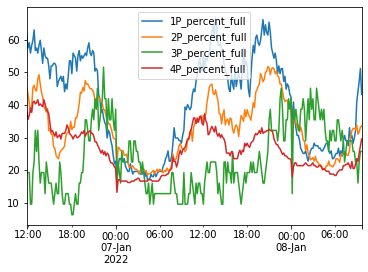

In [943]:
dates = estimation_data.index.get_level_values(0)
macro_time_df_all = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    for _type in ['1P', '2P', '3P', '4P']:
        date_df = estimation_data.loc[date]
        macro_time_df_all.loc[date, f'{_type}_percent_full'] = 100*date_df.loc[date_df[_type] == 1, 'status'].sum() / date_df.loc[date_df[_type] == 1, 'status'].count()


macro_time_df_all.plot()

In [944]:
# extract test and train data
most_recent = np.max(estimation_data.index.get_level_values(0))

test = estimation_data.loc[(most_recent - timedelta(minutes = 100)):]
train = estimation_data.loc[:(most_recent - timedelta(minutes = 100))]

X_test = test[['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]
Y_test = test['status']
X_train = train[['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]
Y_train = train['status']

In [921]:
X_test

lag1  lag2  lag3  1P  2P  3P  4P
datetime            bay_id                                  
2022-01-07 20:30:00 856        1     1     1   0   1   0   0
                    857        1     1     1   0   1   0   0
                    863        1     1     1   1   0   0   0
                    864        1     1     1   0   0   0   0
                    869        0     0     0   0   1   0   0
...                          ...   ...   ...  ..  ..  ..  ..
2022-01-07 22:10:00 8344       1     1     1   1   0   0   0
                    8345       1     1     1   1   0   0   0
                    8347       1     1     1   0   0   0   0
                    8348       1     1     1   0   0   0   0
                    8890       1     1     1   0   1   0   0

[8591 rows x 7 columns]

# Modelling

Using the features we have extracted, we now estimate a model which classifies a parking space as occupied or empty.


In [909]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


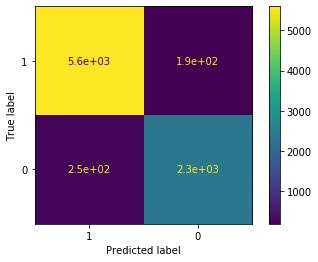

In [945]:
LR = LogisticRegression(random_state=1)
LR.fit(X_train, Y_train)

pred = LR.predict(X_test)
cm = confusion_matrix(Y_test, pred)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

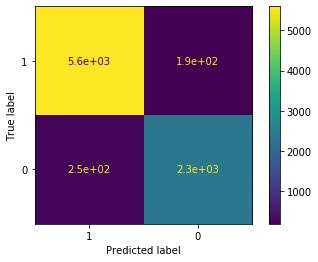

In [968]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 5, ccp_alpha = 0.1)
rf.fit(X_train, Y_train)

pred = rf.predict(X_test)
cm = confusion_matrix(Y_test, pred)
ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()

In [948]:
acc = {'acc': [], 'occ': []}

for date in np.unique(X_test.index.get_level_values(0)):
    pred = LR.predict(X_test.loc[date])
    cm = confusion_matrix(Y_test.loc[date], pred)
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    occupancy = 100* pred.sum() / len(pred)
    acc['acc'].append(accuracy)
    acc['occ'].append(occupancy)
    #ConfusionMatrixDisplay(cm, display_labels = [1,0]).plot()


In [946]:
def combine_preds(X, Y, pred):
    
    curr_date = np.max(X.index.get_level_values(0))
    # get next interval
    next_date = curr_date + timedelta(minutes = 10)

    # update indicies and get new df
    new_date_index = np.tile(next_date, len(pred))
    new_park_index = X.index.get_level_values(1).unique()
    new_multi_index = pd.MultiIndex.from_tuples(list(zip(new_date_index, new_park_index)))

    new_data = pd.DataFrame({'status' : pred}, index = new_multi_index)

    # merge and create combined df
    temp_train = pd.merge(X, Y, left_index = True, right_index = True)
    combined = pd.concat([new_data, temp_train])
    combined.sort_index(inplace = True)

    # update lagged values
    for i in [1,2,3]:

        s = next_date - timedelta(minutes = i*10)
        lag_vals = Y.loc[s, ].to_numpy()
        #print(lag_vals.shape, combined.loc[next_data].shape)
        combined.loc[next_date, f'lag{i}'] = lag_vals
    
    

    return combined

def iterative_forecast(model, X_train, Y_train, X_test, n_ahead):
    train_vars = X_train
    train_target = Y_train
    
    last_date = np.max(X_train.index.get_level_values(0)) 

    test_vars = X_test.loc[last_date + timedelta(minutes = 10),]


    # iterate through dates
    for i in range(1, n_ahead + 1):
        pred = model.predict(test_vars) # already fitted model

        new_data = combine_preds(train_vars, train_target, pred)

        train_target = new_data['status']
        train_vars = new_data[['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]
        test_vars = new_data.loc[last_date + timedelta(minutes = 10 * i),['lag1', 'lag2', 'lag3', '1P', '2P', '3P', '4P']]

    return new_data.loc[last_date + timedelta(minutes = 10):,]


#LR.predict(X_test)
#k = combine_preds(X_train, Y_train, LR.predict(X_test))
fcast = iterative_forecast(LR, X_train, Y_train, X_test, 10)



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

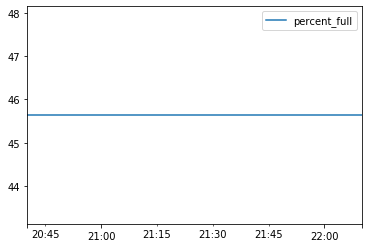

In [847]:


fcast_occ = pd.DataFrame(index = np.unique(fcast.index.get_level_values(0)))

for date in np.unique(fcast.index.get_level_values(0)):

    fcast_occ.loc[date, 'percent_full'] = 100*fcast.loc[date, 'status'].sum() / fcast.loc[date, 'status'].count()


fcast_occ.plot()

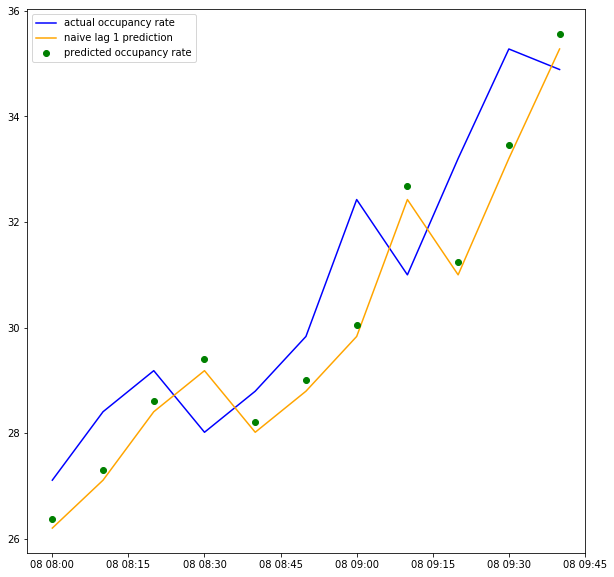

In [951]:
acc_df = pd.DataFrame(acc, index = np.unique(X_test.index.get_level_values(0)))
## analyse the implied occupancy rate
plt.figure(figsize = (10,10))
# does not really provide an advantage over a naive lagged 1 prediction
plt.plot(macro_time_df.loc[most_recent - timedelta(minutes = 100):, 'percent_full'], c = 'blue', label = 'actual occupancy rate')
plt.plot(macro_time_df.loc[most_recent - timedelta(minutes = 100):, 'lag1_pred'], c = 'orange', label = 'naive lag 1 prediction')
#plt.plot(fcast_occ.index, fcast_occ['percent_full'], 'or', label = 'predicted')
plt.plot(acc_df['occ'].index, acc_df['occ'],'og', label = 'predicted occupancy rate')
plt.legend()
plt.show()


In [961]:
print(np.mean((macro_time_df.loc[most_recent - timedelta(minutes = 100):, 'percent_full'] - acc_df['occ'])**2),
np.mean((macro_time_df.loc[most_recent - timedelta(minutes = 100):, 'percent_full'] - macro_time_df.loc[most_recent - timedelta(minutes = 100):, 'lag1_pred'])**2))

1.9175945808721588 2.2037510871558315


[[ 4.05025946  1.09769785  1.19256066  0.04192595 -0.08930877 -0.20385957
  -0.27244868]]


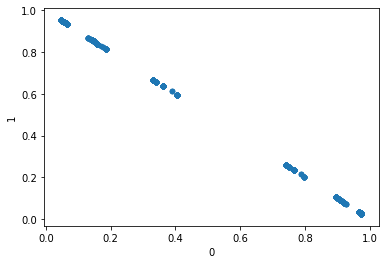

In [952]:
pd.DataFrame(LR.predict_proba(X_test)).plot(x = 0, y = 1,kind = 'scatter')
print(LR.coef_)

In [339]:
# TODO

# extract available hours for each park and 

In [452]:
acc_df

,acc
0,0.917673
1,0.912281
2,0.926535
3,0.936404


unique_parks

(array([0.0911828 , 0.04      , 0.02731183, 0.01935484, 0.0083871 ,
        0.00623656, 0.00344086, 0.00236559, 0.00086022, 0.00086022]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

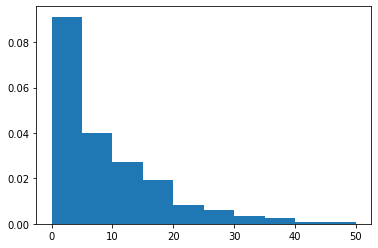

In [337]:
# count the number of status changes
df['change'] = df.status != df.lag1
changes = df.loc[~df.change.isna(),'change'].groupby(level = 'bay_id').sum()

# can look at changes per hour? changes by area? plot this as a graph?
plt.hist(changes - 1, density = True)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
C:\ProgramData\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


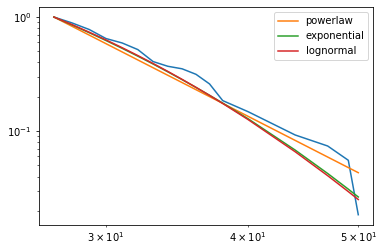

In [338]:

res = powerlaw.Fit(changes - 1)
fig = res.plot_ccdf()
res.power_law.plot_ccdf(ax = fig, label = 'powerlaw')
res.exponential.plot_ccdf(ax = fig, label = 'exponential')
res.lognormal.plot_ccdf(ax = fig, label = 'lognormal')
fig.legend()

In [233]:
# think about:
# what variables do you want for predictions? e.g. lags, neighbouring occupancy, parking restrictions
# what are some overall statistics? e.g. changes per hour, % occupied,% unoccupied (at a time, or in an area or both)
# what sort of model? - thinking classification model, using lags and other variables. start with logisitic regression?


,bay_id,datetime,st_marker_id,status,lag1,lag2,lag3,change
0,4432,2022-01-06 11:20:00,C7704,0,NaN,NaN,NaN,True
1,5236,2022-01-06 11:20:00,11526N,0,NaN,NaN,NaN,True
2,2655,2022-01-06 11:20:00,10159W,1,NaN,NaN,NaN,True
3,2670,2022-01-06 11:20:00,10179W,1,NaN,NaN,NaN,True
4,1274,2022-01-06 11:20:00,4466E,0,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...
119938,2643,2022-01-07 10:30:00,10117W,0,1.0,0.0,0.0,True
119939,4422,2022-01-07 10:30:00,C7684,1,1.0,1.0,1.0,False
119940,4086,2022-01-07 10:30:00,C6286,1,1.0,1.0,1.0,False
119941,8335,2022-01-07 10:30:00,C7736C,0,0.0,0.0,0.0,False


Below we look at the % occupancy of parking spots across the City of Melbourne by time.

In [277]:
df_time = df.copy(deep = True)
df_time.reset_index(inplace = True)

dates = pd.DatetimeIndex(df_time.datetime)

df_time = df_time[['bay_id', 'status', 'lag1', 'lag2', 'lag3']].set_index(dates)

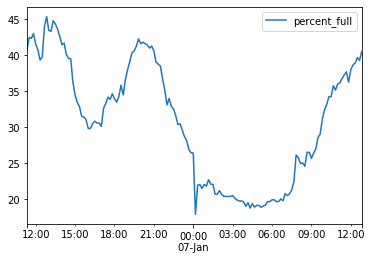

In [278]:
macro_time_df = pd.DataFrame(index = np.unique(dates))


for date in np.unique(dates):
    macro_time_df.loc[date, 'percent_full'] = 100*df_time.loc[date, 'status'].sum() / df_time.loc[date, 'status'].count()

macro_time_df.plot()

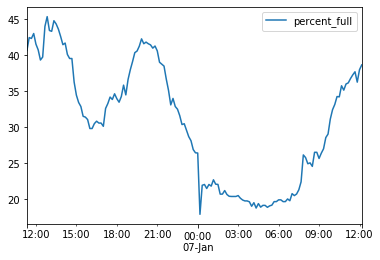